<a href="https://colab.research.google.com/github/madanmohan-venkatesan/notebooks/blob/main/2011_03567.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.special import gammaln,xlogy,logsumexp
from matplotlib import pyplot as plt
import seaborn as sns

# 2. A sequential multinomial test


In [2]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100

In [3]:
theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
rng = np.random.default_rng()
vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)

In [4]:
K=100
alpha_dirichlet=K*theta_null
rng = np.random.default_rng()
theta_alt=rng.dirichlet(alpha_dirichlet)
vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

In [5]:
s_n_null=np.sum(vectors_null,axis=0)
s_n_alt=np.sum(vectors_alt,axis=0)

In [6]:
def beta(v):

  gamma_v=gamma(v)
  numerator=np.prod(v,where=np.isfinite(gamma_v))
  denominator=gamma(np.sum(v,where=np.isfinite(v)))
  result=numerator/denominator
  if np.isnan(result).any():
    return np.array([np.inf])
  else:
    return result


In [7]:
def bf_10(dirichlet_alpha,theta,counts):
  term1_numerator=beta(dirichlet_alpha+counts)
  term1_denominator=beta(dirichlet_alpha)
  term1=term1_numerator/term1_denominator

  term2=1/(theta**counts)
  result=term1*term2

  if np.isnan(result).any() or np.isinf(result).any():
    return np.array([np.inf]*len(result))
  else:
    return result


In [8]:
bf_10(alpha_dirichlet,theta_null,s_n_alt)

array([0., 0.])

For above bf_10, if theta_0 not equal theta then values will go to infinity (reject null hypothesis)
otherwise value is zero(accept null hypothesis)

Hyper paramters to play around with are K and vector size



# Optimization problem for theta

In [9]:
def objective(theta, i,maximize=True):
    """
    Objective function to maximize theta_i.

    Parameters:
    - theta (array): Probability vector (simplex).
    - i (int): Index of the element to maximize.

    Returns:
    - float: Negative of theta[i] to convert minimization to maximization.
    """
    if maximize:
        return -theta[i]
    else:
      return theta[i]

def constraint_sum(theta):
    """
    Constraint ensuring that the sum of theta is 1.

    Parameters:
    - theta (array): Probability vector (simplex).

    Returns:
    - float: Sum of theta - 1 (should be 0).
    """
    return np.sum(theta) - 1

def constraint_log_likelihood(theta, Sn, c):
    """
    Log-likelihood constraint.

    Parameters:
    - theta (array): Probability vector (simplex).
    - Sn (array): Observed count vector S_{n,i}.
    - c (float): Constant c + log u.

    Returns:
    - float: Left-hand side of the constraint.
    """

    epsilon = 1e-10
    return np.sum(Sn * np.log(np.clip(theta, epsilon, None))) - c

# Real simulation

# Without numerical stability

In [10]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100
epsilon = 1e-10

theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
rng = np.random.default_rng()
vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)
K=100
alpha_dirichlet=K*theta_null
rng = np.random.default_rng()
theta_alt=rng.dirichlet(alpha_dirichlet)
vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)


on_theta_hist_arr=[]
theta_alt_1max_arr=[]
theta_alt_1min_arr=[]

theta_alt_0max_arr=[]
theta_alt_0min_arr=[]

seq_p_val_arr=[]
counter=0
for i in range(0,VECTOR_SIZE,int(VECTOR_SIZE/100)):

  on_theta_prev = None
  vectors_null_i=[]
  vectors_alt_i=[]
  if counter==0:
    on_theta_prev = np.array([1]*CLASSES)
    vectors_null_i=vectors_null[counter]
    vectors_alt_i=vectors_alt[counter]
    on_theta_hist_arr.append(on_theta_prev)
    seq_p_val_arr.append(np.array([1]*CLASSES))
  else:
    vectors_null_i=vectors_null[:i]
    vectors_alt_i=vectors_alt[:i]

  s_n_null=np.sum(vectors_null_i,axis=0)
  s_n_alt=np.sum(vectors_alt_i,axis=0)

  term1_numerator=beta(alpha_dirichlet+s_n_alt)
  term1_denominator=beta(alpha_dirichlet)
  term1=term1_numerator/term1_denominator

  term2=1/(theta_null**s_n_alt)
  on_theta_curr=on_theta_hist_arr[-1]*term1*term2
  print(counter)


  if ((on_theta_curr >= 1/0.05).any()) or (np.isnan(on_theta_curr).any()):
    print("Reject null hypothesis")
    break
  else:
    print("Accept null hypothesis")

  if ((on_theta_curr < 1/0.05).any()) or (np.isnan(on_theta_curr).any()):
    print("proceeding with optimization")
  else:
    print("Reject null hypothesis")
    break

  c = np.log(beta(alpha_dirichlet+s_n_alt)) - np.log(beta(alpha_dirichlet))  # Example constant for log Beta terms
  u = 0.05  # Example confidence level
  c += np.log(u)

  # Initial guess for theta (uniform distribution)
  initial_theta = np.full(len(theta_alt), 1 / len(theta_alt))

  # Constraints
  constraints = [
      {'type': 'eq', 'fun': constraint_sum},
      {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
  ]

  # Bounds to ensure theta remains within [0, 1]
  bounds = [(0, 1) for _ in range(len(theta_alt))]

  # Solve the optimization problem
  result0 = minimize(objective, initial_theta, args=(0,True), bounds=bounds, constraints=constraints, method='SLSQP')
  result1 = minimize(objective, initial_theta, args=(1,True), bounds=bounds, constraints=constraints, method='SLSQP')

  # Display the result
  if result0.success:
      theta_alt_0max_arr.append(result0.x[0])
  else:
      print("Optimization failed:", result0.message)
      break

  if result1.success:
      theta_alt_1max_arr.append(result1.x[0])
  else:
      print("Optimization failed:", result1.message)
      break




  # Solve the optimization problem

  result0 = minimize(objective, initial_theta, args=(0,False), bounds=bounds, constraints=constraints, method='SLSQP')
  result1 = minimize(objective, initial_theta, args=(1,False), bounds=bounds, constraints=constraints, method='SLSQP')

  # Display the result
  if result0.success:
      theta_alt_0min_arr.append(result0.x[0])
  else:
      print("Optimization failed:", result0.message)
      break

  if result1.success:
      theta_alt_1min_arr.append(result1.x[0])
  else:
      print("Optimization failed:", result1.message)
      break
  if counter>0:
    on_theta_hist_arr.append(on_theta_curr)
    # p_val=np.clip(1/on_theta_curr,1/on_theta_curr,seq_p_val_arr[counter-1])
    p_val=np.minimum(seq_p_val_arr[-1],1/on_theta_curr+epsilon)
    seq_p_val_arr.append(p_val)

  counter+=1

0
Accept null hypothesis
proceeding with optimization
1
Accept null hypothesis
proceeding with optimization
2
Accept null hypothesis
proceeding with optimization
3
Accept null hypothesis
proceeding with optimization
4
Accept null hypothesis
proceeding with optimization
5
Accept null hypothesis
proceeding with optimization
6
Accept null hypothesis
proceeding with optimization
7
Accept null hypothesis
proceeding with optimization
8
Accept null hypothesis
proceeding with optimization
9
Accept null hypothesis
proceeding with optimization
10
Accept null hypothesis
proceeding with optimization
11
Accept null hypothesis
proceeding with optimization
12
Accept null hypothesis
proceeding with optimization
13
Accept null hypothesis
proceeding with optimization
14
Accept null hypothesis
proceeding with optimization
15
Accept null hypothesis
proceeding with optimization
16
Accept null hypothesis
proceeding with optimization
17
Accept null hypothesis
proceeding with optimization
18
Accept null hypot

<ipython-input-10-58b18a80af1a>:120: RuntimeWarning: divide by zero encountered in divide
  p_val=np.minimum(seq_p_val_arr[-1],1/on_theta_curr+epsilon)
<ipython-input-10-58b18a80af1a>:120: RuntimeWarning: overflow encountered in divide
  p_val=np.minimum(seq_p_val_arr[-1],1/on_theta_curr+epsilon)


19
Accept null hypothesis
proceeding with optimization
20
Accept null hypothesis
proceeding with optimization
21
Accept null hypothesis
proceeding with optimization
22
Accept null hypothesis
proceeding with optimization
23
Accept null hypothesis
proceeding with optimization
24
Accept null hypothesis
proceeding with optimization
25
Accept null hypothesis
proceeding with optimization
26
Accept null hypothesis
proceeding with optimization
27
Accept null hypothesis
proceeding with optimization
28
Accept null hypothesis
proceeding with optimization
29
Accept null hypothesis
proceeding with optimization
30
Accept null hypothesis
proceeding with optimization
31
Accept null hypothesis
proceeding with optimization
32
Accept null hypothesis
proceeding with optimization
33
Accept null hypothesis
proceeding with optimization
34
Accept null hypothesis
proceeding with optimization
35
Accept null hypothesis
proceeding with optimization
36
Accept null hypothesis
proceeding with optimization
37
Accept 

<ipython-input-10-58b18a80af1a>:64: RuntimeWarning: divide by zero encountered in log
  c = np.log(beta(alpha_dirichlet+s_n_alt)) - np.log(beta(alpha_dirichlet))  # Example constant for log Beta terms
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


# With numerical stability of log liklihood

In [11]:
# Updated objective function
def objective(theta, i, maximize=True):
    """
    Objective function to maximize or minimize theta_i.

    Parameters:
    - theta (array): Probability vector (simplex).
    - i (int): Index of the element to optimize.
    - maximize (bool): True to maximize, False to minimize.

    Returns:
    - float: Optimized theta[i] (negative for maximization).
    """
    if maximize:
        return -theta[i]  # Maximize by minimizing the negative
    else:
        return theta[i]  # Minimize directly

# Constraint for the sum of theta to be 1 (simplex condition)
def constraint_sum(theta):
    return np.sum(theta) - 1

# Log-likelihood constraint with numerical stability

def log_with_numerical_statibility(value):
    """
    Logarithm with numerical stability.

    Parameters:
    - value (float): Input value.

    Returns:
    - float: Logarithm of the input value.
    """

    epsilon = 1e-99  # Small constant for numerical stability
    return np.log(np.clip(value, epsilon, None))
epsilon = 1e-99  # Small constant for numerical stability

def constraint_log_likelihood(theta, Sn, c):
    """
    Log-likelihood constraint ensuring numerical stability.

    Parameters:
    - theta (array): Probability vector (simplex).
    - Sn (array): Observed count vector S_{n,i}.
    - c (float): Constant c + log u.

    Returns:
    - float: Result of the log-likelihood constraint.
    """
    return np.sum(Sn * log_with_numerical_statibility(theta)) - c

# Constants
CLASSES = 2
VECTOR_SIZE = 100
theta_null = np.array([1 / CLASSES] * CLASSES)  # Initial null hypothesis (simplex)
rng = np.random.default_rng()
vectors_null = rng.multinomial(1, theta_null, size=VECTOR_SIZE)
K = 100
alpha_dirichlet = K * theta_null
theta_alt = rng.dirichlet(alpha_dirichlet)
vectors_alt = rng.multinomial(1, theta_alt, size=VECTOR_SIZE)

# Storage for results
theta_alt_1max_arr = []
theta_alt_1min_arr = []
theta_alt_0max_arr = []
theta_alt_0min_arr = []

seq_p_val_arr = []
counter = 0
NULL_REJECTED = False
# Iterative procedure for calculating bounds
for i in range(0, VECTOR_SIZE, 1):#VECTOR_SIZE // 100):
  if not NULL_REJECTED:
      vectors_null_i = []
      vectors_alt_i = []

      if counter == 0:
          on_theta_prev = np.array([1] * CLASSES)
          vectors_null_i = vectors_null[counter]
          vectors_alt_i = vectors_alt[counter]
          seq_p_val_arr.append(np.array([1] * CLASSES))
      else:
          vectors_null_i = vectors_null[:i]
          vectors_alt_i = vectors_alt[:i]

      s_n_null = np.sum(vectors_null_i, axis=0)
      s_n_alt = np.sum(vectors_alt_i, axis=0)

      # Calculate term1 for the Bayesian update
      term1_numerator = beta(alpha_dirichlet + s_n_alt)
      term1_denominator = beta(alpha_dirichlet)
      term1 = term1_numerator / term1_denominator

      # Ensure numerical stability for the term2 calculation
      term2 = 1 / (theta_null**s_n_alt + epsilon)
      on_theta_curr = seq_p_val_arr[-1] * term1 * term2

      print(f"Iteration {counter}")

      # Check and update p-values
      if ((on_theta_curr >= 1 / 0.05).any()) or (np.isnan(on_theta_curr).any()):
          print("Reject null hypothesis")
          break
      else:
          print("Accept null hypothesis")
      print(beta(alpha_dirichlet + s_n_alt))
      print(beta(alpha_dirichlet))

      c = log_with_numerical_statibility(beta(alpha_dirichlet + s_n_alt)) - log_with_numerical_statibility(beta(alpha_dirichlet)) + epsilon
      print(c)
      u = 0.05  # Confidence level
      c += log_with_numerical_statibility(u)
      print(c)

      # Initial guess for theta (uniform distribution)
      initial_theta = np.full(len(theta_alt), 1 / len(theta_alt))

      # Constraints
      constraints = [
          {'type': 'eq', 'fun': constraint_sum},
          {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
      ]

      # Bounds to ensure theta remains in the range [0, 1]
      # bounds = [(0, 1) for _ in range(len(theta_alt))]
      bounds = [(epsilon, 1 - epsilon) for _ in range(len(theta_alt))]

      # Maximize theta for both classes
      for j in range(CLASSES):
          result_max = minimize(objective, initial_theta, args=(j, True), bounds=bounds, constraints=constraints, method='trust-constr')
          if result_max.success:
              if j == 0:
                  theta_alt_0max_arr.append(result_max.x[0])
              else:
                  theta_alt_1max_arr.append(result_max.x[1])
          else:
              print(f"Optimization failed for max class {j}:", result_max.message)
              NULL_REJECTED = True
              break

      # Minimize theta for both classes
      for j in range(CLASSES):
          result_min = minimize(objective, initial_theta, args=(j, False), bounds=bounds, constraints=constraints, method='trust-constr')
          if result_min.success:
              if j == 0:
                  theta_alt_0min_arr.append(result_min.x[0])
              else:
                  theta_alt_1min_arr.append(result_min.x[1])
          else:
              print(f"Optimization failed for min class {j}:", result_min.message)
              NULL_REJECTED = True
              break

      if counter > 0 and not NULL_REJECTED:
          p_val = np.minimum(seq_p_val_arr[-1], 1 / on_theta_curr)
          seq_p_val_arr.append(p_val)


      counter += 1

  # Plot or further analysis can be done to visualize the non-overlapping nature of CIs


Iteration 0
Accept null hypothesis
2.7594042172419207e-157
2.6787757203136665e-153
1e-99
-2.995732273553991


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


Iteration 1
Accept null hypothesis
2.7323512347199407e-155
2.6787757203136665e-153
1e-99
-2.995732273553991
Iteration 2
Accept null hypothesis
2.758343315966549e-157
2.6787757203136665e-153
1e-99
-2.995732273553991
Iteration 3
Accept null hypothesis
2.756263117387388e-159
2.6787757203136665e-153
1e-99
-2.995732273553991
Iteration 4
Accept null hypothesis
2.7264738658897043e-161
2.6787757203136665e-153
1e-99
-2.995732273553991
Iteration 5
Accept null hypothesis
2.674041676161056e-163
2.6787757203136665e-153
1e-99
-2.995732273553991
Iteration 6
Accept null hypothesis
2.5966417770378137e-165
2.6787757203136665e-153
1e-99
-2.995732273553991
Optimization failed for max class 0: The maximum number of function evaluations is exceeded.
Optimization failed for min class 0: The maximum number of function evaluations is exceeded.


# With numerical stability of O_n theta and log likelihood

In [12]:
alpha_dirichlet
theta_alt

array([0.49578148, 0.50421852])

In [13]:
def calculate_log_beta(alpha):
        """
        Numerically stable calculation of log(beta(alpha)).

        Parameters:
        - alpha (array-like): Array of alpha values.

        Returns:
        - float: Logarithm of the beta function value.
        """
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

In [14]:

# Updated objective function
def objective(theta, i, maximize=True):
    return -theta[i] if maximize else theta[i]

def constraint_sum(theta):
    return np.sum(theta) - 1

epsilon = 1e-10  # Small constant for numerical stability

def constraint_log_likelihood(theta, Sn, c):
  clipped_theta = np.clip(theta, epsilon, 1 - epsilon)
  return np.sum(Sn * np.log(np.clip(theta, epsilon, None))) - c

# Constants
CLASSES = 2
VECTOR_SIZE = 10000
theta_null = np.array([1 / CLASSES] * CLASSES)
rng = np.random.default_rng()
vectors_null = rng.multinomial(1, theta_null, size=VECTOR_SIZE)
K = 45

alpha_dirichlet = K * theta_null
theta_alt = rng.dirichlet(alpha_dirichlet)
vectors_alt = rng.multinomial(1, theta_alt, size=VECTOR_SIZE)

on_theta_hist_arr=[]
theta_alt_1max_arr = []
theta_alt_1min_arr = []
theta_alt_0max_arr = []
theta_alt_0min_arr = []

seq_p_val_arr = []
counter = 0

for i in range(0, VECTOR_SIZE, VECTOR_SIZE // 100):
    break_outer_loop = False
    vectors_null_i = []
    vectors_alt_i = []

    if counter == 0:
        on_theta_prev = np.array([1] * CLASSES)
        vectors_null_i = vectors_null[counter]
        vectors_alt_i = vectors_alt[counter]
        on_theta_hist_arr.append(on_theta_prev)
        seq_p_val_arr.append(np.array([1] * CLASSES))
    else:
        vectors_null_i = vectors_null[:i]
        vectors_alt_i = vectors_alt[:i]

    s_n_null = np.sum(vectors_null_i, axis=0)
    s_n_alt = np.sum(vectors_alt_i, axis=0)

    log_beta_numerator = calculate_log_beta(alpha_dirichlet + s_n_alt)
    log_beta_denominator = calculate_log_beta(alpha_dirichlet)
    log_beta_ratio = log_beta_numerator - log_beta_denominator

    log_theta_term = -np.sum(s_n_alt * np.log(np.clip(theta_null, 1e-10, None)))
    on_theta_curr = log_beta_ratio + log_theta_term + np.log(on_theta_hist_arr[-1])


    print("on_theta",on_theta_curr)
    on_theta_curr=np.exp(on_theta_curr)

    print(f"Iteration {counter}")

    if ((on_theta_curr >= 1 / 0.05).any()) or (np.isnan(on_theta_curr).any()):
        print("Reject null hypothesis")
    else:
        print("Accept null hypothesis")


    def calculate_log_beta(alpha):
        """
        Numerically stable calculation of log(beta(alpha)).

        Parameters:
        - alpha (array-like): Array of alpha values.

        Returns:
        - float: Logarithm of the beta function value.
        """
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

    # Replace the calculation of c with the new function
    c = calculate_log_beta(alpha_dirichlet + s_n_alt) - calculate_log_beta(alpha_dirichlet)
    u = 0.05  # Confidence level
    c += np.log(u)

    initial_theta = np.array([1 / CLASSES] * CLASSES)

    constraints = [
        {'type': 'eq', 'fun': constraint_sum},
        {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
    ]

    bounds = [(epsilon, 1 - epsilon) for _ in range(len(theta_alt))]

    # Maximize theta for both classes
    for j in range(CLASSES):
        result_max = minimize(objective, initial_theta, args=(j, True), bounds=bounds, \
                              constraints=constraints, method='SLSQP')
        if result_max.success:
            if j == 0:
                theta_alt_0max_arr.append(result_max.x[0])
            else:
                theta_alt_1max_arr.append(result_max.x[1])
        else:
            print(f"Optimization failed for max class {j}:", result_max.message)
            break_outer_loop = True
            break

    if break_outer_loop:
        break

    # Minimize theta for both classes
    for j in range(CLASSES):
        result_min = minimize(objective, initial_theta, args=(j, False), bounds=bounds, \
                              constraints=constraints, method='SLSQP')
        if result_min.success:
            if j == 0:
                theta_alt_0min_arr.append(result_min.x[0])
            else:
                theta_alt_1min_arr.append(result_min.x[1])
        else:
            print(f"Optimization failed for min class {j}:", result_min.message)
            break_outer_loop = True
            break

    if break_outer_loop:
        break

    if counter > 0 and not break_outer_loop:
        on_theta_hist_arr.append(on_theta_curr)
        p_val = np.minimum(seq_p_val_arr[-1], 1 / (on_theta_curr+epsilon))
        seq_p_val_arr.append(p_val)

    counter += 1


on_theta [-0.02197891 -0.02197891]
Iteration 0
Accept null hypothesis
on_theta [1.09826076 1.09826076]
Iteration 1
Accept null hypothesis
on_theta [3.53994357 3.53994357]
Iteration 2
Reject null hypothesis
on_theta [7.42962659 7.42962659]
Iteration 3
Reject null hypothesis
on_theta [10.34540434 10.34540434]
Iteration 4
Reject null hypothesis
on_theta [17.25546509 17.25546509]
Iteration 5
Reject null hypothesis
on_theta [23.71447778 23.71447778]
Iteration 6
Reject null hypothesis
on_theta [33.37161423 33.37161423]
Iteration 7
Reject null hypothesis
on_theta [45.66218078 45.66218078]
Iteration 8
Reject null hypothesis
on_theta [60.26269961 60.26269961]
Iteration 9
Reject null hypothesis
on_theta [76.81492203 76.81492203]
Iteration 10
Reject null hypothesis
on_theta [96.47753115 96.47753115]
Iteration 11
Reject null hypothesis
on_theta [119.29626635 119.29626635]
Iteration 12
Reject null hypothesis
on_theta [146.97355098 146.97355098]
Iteration 13
Reject null hypothesis
on_theta [174.9616

<ipython-input-14-eca7bdf1666b>:62: RuntimeWarning: overflow encountered in exp
  on_theta_curr=np.exp(on_theta_curr)


on_theta [inf inf]
Iteration 28
Reject null hypothesis
on_theta [inf inf]
Iteration 29
Reject null hypothesis
on_theta [inf inf]
Iteration 30
Reject null hypothesis
on_theta [inf inf]
Iteration 31
Reject null hypothesis
on_theta [inf inf]
Iteration 32
Reject null hypothesis
on_theta [inf inf]
Iteration 33
Reject null hypothesis
on_theta [inf inf]
Iteration 34
Reject null hypothesis
on_theta [inf inf]
Iteration 35
Reject null hypothesis
on_theta [inf inf]
Iteration 36
Reject null hypothesis
on_theta [inf inf]
Iteration 37
Reject null hypothesis
on_theta [inf inf]
Iteration 38
Reject null hypothesis
on_theta [inf inf]
Iteration 39
Reject null hypothesis
on_theta [inf inf]
Iteration 40
Reject null hypothesis
on_theta [inf inf]
Iteration 41
Reject null hypothesis
on_theta [inf inf]
Iteration 42
Reject null hypothesis
on_theta [inf inf]
Iteration 43
Reject null hypothesis
on_theta [inf inf]
Iteration 44
Reject null hypothesis
on_theta [inf inf]
Iteration 45
Reject null hypothesis
on_theta [

[]

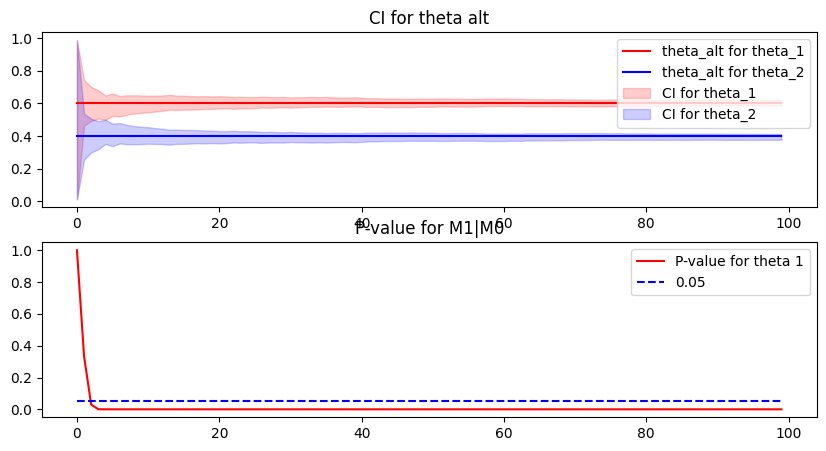

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.title("CI for theta alt")
lenght=len(theta_alt_0min_arr)
plt.plot(range(lenght),[theta_alt[0]]*lenght,color='r',label="theta_alt for theta_1")
plt.plot(range(lenght),[theta_alt[1]]*lenght,color='b',label="theta_alt for theta_2")

plt.fill_between(range(lenght),
                 np.array(theta_alt_0min_arr),
                 np.array(theta_alt_0max_arr), color='r',
                 alpha=0.2, label="CI for theta_1")  # alpha controls transparency


plt.fill_between(range(lenght),
                 np.array(theta_alt_1min_arr),
                 np.array(theta_alt_1max_arr), color='b',
                 alpha=0.2, label="CI for theta_2")  # alpha controls transparency



plt.legend()
plt.subplot(2,1,2)
plt.title("P-value for M1|M0")
plt.plot(range(lenght),np.array(seq_p_val_arr)[:,0],color='r',label="P-value for theta 1")
plt.plot(range(lenght),[0.05]*lenght,'--',color='b',label="0.05")
plt.legend()
plt.plot()


# Inhomogeneous Bernoulli processes

In [16]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100000

In [17]:
#arm1
assignment_prb_null_arm1=np.array([1/CLASSES]*CLASSES)
K_arm1=45
alpha_dirichlet_arm1=K*assignment_prb_null_arm1
rng = np.random.default_rng()
assignment_prb_alt_arm1=rng.dirichlet(alpha_dirichlet_arm1)
vectors_alt_arm1=rng.multinomial(1,assignment_prb_alt_arm1,size=VECTOR_SIZE)

successful_trials_arm1=vectors_alt_arm1[:,1]
rho_alt_arm1=successful_trials_arm1.sum()/VECTOR_SIZE
mu_class_1_arm1=successful_trials_arm1.mean()
sn_class_1_arm1=successful_trials_arm1.sum()
prob_class_1_arm1=sn_class_1_arm1/successful_trials_arm1.shape[0]
# del_class_1_arm1=np.log(prob_class_1_arm1)/mu_class_1_arm1

In [18]:
#arm2
assignment_prb_null_arm2=np.array([1/CLASSES]*CLASSES)
K_arm2=45
alpha_dirichlet_arm2=K*assignment_prb_null_arm2
rng = np.random.default_rng()
assignment_prb_alt_arm2=rng.dirichlet(alpha_dirichlet_arm2)
vectors_alt_arm2=rng.multinomial(1,assignment_prb_alt_arm2,size=VECTOR_SIZE)

successful_trials_arm2=vectors_alt_arm2[:,1]
rho_alt_arm2=successful_trials_arm2.sum()/VECTOR_SIZE
mu_class_1_arm2=successful_trials_arm2.mean()
sn_class_1_arm2=successful_trials_arm2.sum()
prob_class_1_arm2=sn_class_1_arm2/successful_trials_arm2.shape[0]
# del_class_1_arm2=np.log(prob_class_1_arm2)/mu_class_1_arm2

mu_tot=np.concatenate((successful_trials_arm1,successful_trials_arm2)).mean()

del_class_1_arm1=np.log(prob_class_1_arm1)-mu_tot
del_class_1_arm2=np.log(prob_class_1_arm2)-mu_tot

In [19]:
rho_alt_arm1

0.68324

In [20]:
rho_obs=[rho_alt_arm1,rho_alt_arm2]
deltas=[del_class_1_arm1,del_class_1_arm2]

numerator=rho_obs*np.exp(deltas)
denominator=np.sum(numerator,axis=0)
theta_i=numerator/denominator
print(rho_obs)
print(theta_i)
print(np.sum(rho_obs))

[0.68324, 0.41963]
[0.72610417 0.27389583]
1.10287


In [21]:
def rho_cal(arms):
  arm1=arms[0]
  arm2=arms[1]

  total_vectors=np.concatenate((arm1,arm2))
  size=total_vectors.shape[0]

  count_arm1=arm1.sum()
  count_arm2=arm2.sum()

  rho_arm1=count_arm1/size
  rho_arm2=count_arm2/size
  return np.array([rho_arm1,rho_arm2])

In [22]:
def prob_cal(arms):
  arm1=arms[0]
  arm2=arms[1]

  prob_arm1=arm1.sum()/arm1.shape[0]
  prob_arm2=arm2.sum()/arm2.shape[0]

  return np.array([prob_arm1,prob_arm2])

In [23]:
def mu_tot_cal(arms):
  return arms.mean()

In [199]:
def del_cal(probability,mu):
  return np.log(probability)-mu

In [25]:
def metrics_cal(arms):
  counts=np.sum(arms,axis=1)
  rhos=rho_cal(arms)
  probs=prob_cal(arms)
  mu=mu_tot_cal(arms)
  deltas=del_cal(probs,mu)
  return {"counts":counts,"rhos":rhos,"probs":probs,"mu":mu,"deltas":deltas}

In [26]:
def calculate_log_beta(alpha):
        """
        Numerically stable calculation of log(beta(alpha)).

        Parameters:
        - alpha (array-like): Array of alpha values.

        Returns:
        - float: Logarithm of the beta function value.
        """
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

In [172]:
def objective(a,delta,maximize=True):
    return -np.dot(a,delta) if maximize else np.dot(a,delta)

def penalty_objective(delta, a, c, counts, rhos, eta, maximize=True):
    obj_value = -np.dot(a, delta) if maximize else np.dot(a, delta)
    constraint_violation = max(0, c - np.sum(counts * (delta + np.log(rhos) - logsumexp(delta + np.log(rhos)))))
    penalty_term = 0.5 * eta * constraint_violation**2
    return obj_value + penalty_term

In [28]:
def constraint(deltas,c,counts,rhos):
  ineq=c-np.sum(counts*(deltas+np.log(rhos)-logsumexp(deltas+np.log(rhos))))
  return ineq

In [200]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=1000
K=100

#arm1
assignment_prb_null_arm1=np.array([1/CLASSES]*CLASSES)
K_arm1=45
alpha_dirichlet_arm1=K*assignment_prb_null_arm1
rng = np.random.default_rng()
assignment_prb_alt_arm1=rng.dirichlet(alpha_dirichlet_arm1)
vectors_alt_arm1=rng.multinomial(1,assignment_prb_alt_arm1,size=VECTOR_SIZE)

#arm2
assignment_prb_null_arm2=np.array([1/CLASSES]*CLASSES)
K_arm2=45
alpha_dirichlet_arm2=K*assignment_prb_null_arm2
rng = np.random.default_rng()
assignment_prb_alt_arm2=rng.dirichlet(alpha_dirichlet_arm2)
vectors_alt_arm2=rng.multinomial(1,assignment_prb_alt_arm2,size=VECTOR_SIZE)

successful_trials_arm1=vectors_alt_arm1[:,1]
successful_trials_arm2=vectors_alt_arm2[:,1]


contrast_a=np.array([-1,1])

hist=[]
upper_bound=[]
lower_bound=[]
counter=0

for i in range(0, VECTOR_SIZE, VECTOR_SIZE // 100):
  if counter == 0:
    counter+=1
    continue
  else:
    vectors_alt_arm1_i=successful_trials_arm1[:i]
    vectors_alt_arm2_i=successful_trials_arm2[:i]

  arms=np.vstack((vectors_alt_arm1_i,vectors_alt_arm2_i))
  metrics=metrics_cal(arms)
  initial_delta = np.random.normal(-0.01, 0.01, size=CLASSES)  # Small random initial guess
  # initial_delta=np.array([1/CLASSES]*CLASSES)
  eta = 1.0


  print(f"Iteration {counter}")

  alpha=K*metrics["rhos"]
  u=0.05
  c=calculate_log_beta(alpha+metrics["counts"])\
  - calculate_log_beta(alpha)\
  + np.log(u)
  # np.random.uniform(-0.1, 0.1, size=CLASSES)
  result_upper = minimize(
    penalty_objective,
    initial_delta,
    args=(contrast_a, c, metrics["counts"], metrics["rhos"], eta, True),  # Arguments for the objective function
    method='L-BFGS-B',  # Unconstrained optimization method
    options={'maxiter': 1000}
)
  result_lower = minimize(
    penalty_objective,
    initial_delta,
    args=(contrast_a, c, metrics["counts"], metrics["rhos"], eta, False),  # Arguments for the objective function
    method='L-BFGS-B',  # Unconstrained optimization method
    options={'maxiter': 1000}
)
  hist.append(metrics)
  if result_upper.success:
    upper_bound.append(result_upper.x[0])
  else:
    print(result_upper.message)
    break

  if result_lower.success:
    lower_bound.append(result_lower.x[0])
  else:
    print(result_lower.message)
    break
  counter+=1






Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

In [201]:
upper_bound

[-1.4641185568122155,
 -0.8449676028753395,
 -0.6661318045471534,
 -0.551656954811577,
 -0.5106297326855929,
 -0.42967452967078895,
 -0.405610178707599,
 -0.37931149705639255,
 -0.35707089158760374,
 -0.33763016763397957,
 -0.31668347754010484,
 -0.2958697819576637,
 -0.29325336268673935,
 -0.28466950317895195,
 -0.26123057125855564,
 -0.24885997785611141,
 -0.2525593834942575,
 -0.25384713487732924,
 -0.24053734778904015,
 -0.23483984155347887,
 -0.22661827888609118,
 -0.22127129998020753,
 -0.23138116162056369,
 -0.2204656536557098,
 -0.2055022665407676,
 -0.2065960723367378,
 -0.20082804069147703,
 -0.20913097523457314,
 -0.19650068686772643,
 -0.18501266770300784,
 -0.17890609873578883,
 -0.18367243500984864,
 -0.19047325397658918,
 -0.17959847464336912,
 -0.19463971498813296,
 -0.1829400772010844,
 -0.17770550228043733,
 -0.17939893707969387,
 -0.1763371514182639,
 -0.17002350669423436,
 -0.1663757224310389,
 -0.17217423392585862,
 -0.16571302301645563,
 -0.16083536173314852,
 -0.

In [202]:
metrics

{'counts': array([407, 375]),
 'rhos': array([0.20555556, 0.18939394]),
 'probs': array([0.41111111, 0.37878788]),
 'mu': 0.39494949494949494,
 'deltas': array([-1.28384125, -1.36572841])}

In [203]:
np.log(del2)

<ipython-input-203-dd4b640b27db>:1: RuntimeWarning: invalid value encountered in log
  np.log(del2)


nan

<ipython-input-192-21a19b2c1920>:3: RuntimeWarning: invalid value encountered in log
  diff=np.log(del2)-np.log(del1)


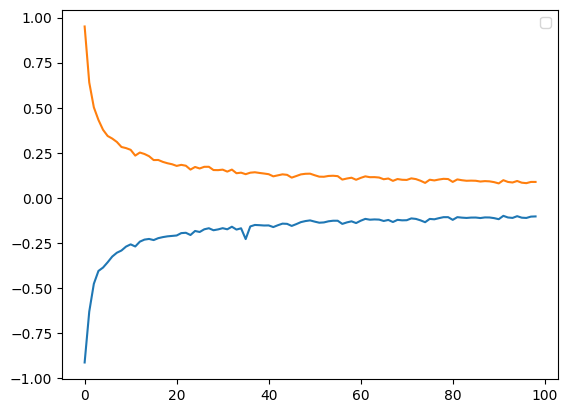

In [192]:
del1=metrics["deltas"][0]
del2=metrics["deltas"][1]
diff=np.log(del2)-np.log(del1)
plt.plot(upper_bound)
plt.plot(lower_bound)
plt.plot([diff]*len(upper_bound))
plt.legend()

In [187]:
-1.28938858+1.09173265

-0.19765593000000004

In [184]:
lower_bound

[0.9503255951778105,
 0.6399969757359631,
 0.5021960498329433,
 0.4323932863848808,
 0.37762380929023076,
 0.34342297987396314,
 0.32907119690718745,
 0.31043128774752493,
 0.28252308734439696,
 0.2762194319611679,
 0.26673898876834895,
 0.2346990594025265,
 0.25172150845272984,
 0.2436687700220572,
 0.23135486743034636,
 0.20994375709196314,
 0.2104907450470174,
 0.19985873817648941,
 0.19234582076150206,
 0.18679305929132947,
 0.17764405205530992,
 0.1834165732915252,
 0.1785512000179067,
 0.15719139042338806,
 0.17170483938380973,
 0.16334276461037694,
 0.17255270278414403,
 0.1727013639699908,
 0.1546462562314835,
 0.15414112919565304,
 0.15684726371252994,
 0.1460007234188131,
 0.1571167616402583,
 0.13698016337132726,
 0.1400996123966711,
 0.13171408129919246,
 0.14004141625348687,
 0.14232241371403442,
 0.13858497128471295,
 0.13532140200477338,
 0.13158122206244388,
 0.11977335237830138,
 0.12529050968103195,
 0.13079744909802968,
 0.12804738394163984,
 0.11264514225829135,
 0.

In [35]:
from scipy.optimize import minimize
from scipy.special import gammaln, logsumexp
import numpy as np

def safe_log(x, epsilon=1e-10):
    return np.log(np.clip(x, epsilon, None))

def calculate_log_beta(alpha):
    return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

def objective(a, delta, maximize=True, regularization=1e-6):
    obj_value = -np.dot(a, delta) if maximize else np.dot(a, delta)
    # return obj_value + regularization * np.sum(delta**2)
    return obj_value

def constraint(deltas, c, counts, rhos):
    log_rhos = safe_log(rhos)
    constraint_value = c - np.sum(counts * (deltas + np.log(rhos) - logsumexp(deltas + log_rhos)))
    # print("Constraint value (stabilized):", constraint_value)
    return constraint_value

# Ensure your data and initial values are scaled and feasible
initial_delta = np.random.uniform(-0.01, 0.01, size=CLASSES)

# Optimization with SLSQP for better handling of numerical issues
print("upper")
result_upper = minimize(
    objective,
    initial_delta,
    args=(contrast_a, True),
    constraints={'type': 'ineq', 'fun': constraint, 'args': (c, metrics["counts"], metrics["rhos"])},
    bounds=[(None, None)] * CLASSES,
    method='SLSQP',
    options={'disp': True, 'maxiter': 500}
)
print("lower")

result_lower = minimize(
    objective,
    initial_delta,
    args=(contrast_a, False),
    constraints={'type': 'ineq', 'fun': constraint, 'args': (c, metrics["counts"], metrics["rhos"])},
    bounds=[(None, None)] * CLASSES,
    method='SLSQP',
    options={'disp': True, 'maxiter': 500}
)

upper
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.18688918462097065
            Iterations: 9
            Function evaluations: 25
            Gradient evaluations: 8
lower
Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: -7.290100122075508e+31
            Iterations: 47
            Function evaluations: 141
            Gradient evaluations: 47


In [95]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln, logsumexp

# Safe log function for numerical stability
def safe_log(x, epsilon=1e-10):
    return np.log(np.clip(x, epsilon, None))

def calculate_log_beta(alpha):
    return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

# Objective function with regularization
def objective(delta, a, maximize=True, regularization=1e-6):
    obj_value = -np.dot(a, delta) if maximize else np.dot(a, delta)
    return obj_value + regularization * np.sum(delta**2)

def constraint(deltas, c, counts, rhos):
    log_rhos = safe_log(rhos)
    constraint_value = c - np.sum(counts * (deltas + log_rhos - logsumexp(deltas + log_rhos)))
    return constraint_value

# Initial guess with perturbation to avoid zero gradient
initial_delta = np.random.uniform(-0.1, 0.1, size=CLASSES)

# Run optimization with 'trust-constr'
result = minimize(
    objective,
    initial_delta,
    args=(contrast_a, True),
    method='SLSQP',
    constraints={'type': 'ineq', 'fun': constraint, 'args': (c, metrics["counts"], metrics["rhos"])},
    bounds=[(None, None)] * CLASSES,
    options={'disp': True, 'maxiter': 1000}
)

if result.success:
    print("Optimal delta:", result.x)
else:
    print("Optimization failed:", result.message)


result = minimize(
    objective,
    initial_delta,
    args=(contrast_a, False),
    method='SLSQP',
    constraints={'type': 'ineq', 'fun': constraint, 'args': (c, metrics["counts"], metrics["rhos"])},
    bounds=[(None, None)] * CLASSES,
    options={'disp': True, 'maxiter': 1000}
)

if result.success:
    print("Optimal delta:", result.x)
else:
    print("Optimization failed:", result.message)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -499999.99928381806
            Iterations: 12
            Function evaluations: 38
            Gradient evaluations: 12
Optimal delta: [-500018.94019778  500018.90637019]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1885036326314522
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimal delta: [-0.04207533  0.14642828]


In [105]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln, logsumexp

# Safe log function for numerical stability
def safe_log(x, epsilon=1e-10):
    return np.log(np.clip(x, epsilon, None))

def calculate_log_beta(alpha):
    return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

# Adjusted objective function with regularization
def objective(delta, a, maximize=True, regularization=1e-3):
    obj_value = -np.dot(a, delta) if maximize else np.dot(a, delta)
    return obj_value + regularization * np.sum(delta**2)

# Constraint function with stabilization
def constraint(deltas, c, counts, rhos):
    log_rhos = safe_log(rhos)
    constraint_value = c - np.sum(counts * (deltas + log_rhos - logsumexp(deltas + log_rhos)))
    return constraint_value

# Normalize inputs for numerical stability
def normalize_data(arr):
    return arr / (np.max(np.abs(arr)) + 1e-10)

# Constants
CLASSES = 2
VECTOR_SIZE = 100000
K = 45

# Simulate data (example)
assignment_prb_null = np.array([1/CLASSES] * CLASSES)
alpha_dirichlet = K * assignment_prb_null
rng = np.random.default_rng()
assignment_prb_alt = rng.dirichlet(alpha_dirichlet)
vectors_alt = rng.multinomial(1, assignment_prb_alt, size=VECTOR_SIZE)

# Calculate counts and rhos
counts = vectors_alt.sum(axis=0)
rhos = normalize_data(assignment_prb_alt)

# Initial guess with perturbation
initial_delta = np.random.uniform(-0.01, 0.01, size=CLASSES)

# Calculate c (constant for the constraint)
u = 0.05  # Confidence level
c = calculate_log_beta(alpha_dirichlet + counts) - calculate_log_beta(alpha_dirichlet) + np.log(u)

# Run optimization
result = minimize(
    objective,
    initial_delta,
    args=(np.array([-1, 1]), True),  # Replace with appropriate contrast vector
    method='trust-constr',
    constraints={'type': 'ineq', 'fun': constraint, 'args': (c, counts, rhos)},
    bounds=[(None, None)] * CLASSES,
    options={'disp': True, 'maxiter': 1000}
)

# Check results
if result.success:
    print("Optimal delta:", result.x)
    print("Optimal objective value:", result.fun)
else:
    print("Optimization failed:", result.message)


`xtol` termination condition is satisfied.
Number of iterations: 709, function evaluations: 2823, CG iterations: 845, optimality: 2.27e-06, constraint violation: 0.00e+00, execution time:  1.5 s.
Optimal delta: [-499.99887705  500.00113209]
Optimal objective value: -499.9999999974574


In [144]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln, logsumexp

# Safe log function for numerical stability
def safe_log(x, epsilon=1e-10):
    return np.log(np.clip(x, epsilon, None))

def calculate_log_beta(alpha):
    return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

# Adjusted objective function with increased regularization
def objective(delta, a, maximize=True, regularization=1e-2):
    obj_value = -np.dot(a, delta) if maximize else np.dot(a, delta)
    return obj_value + regularization * np.sum(delta**2)

# Constraint function with stabilization
def constraint(deltas, c, counts, rhos):
    log_rhos = safe_log(rhos)
    constraint_value = c - np.sum(counts * (deltas + log_rhos - stable_logsumexp(deltas + log_rhos)))
    print(constraint_value)
    return constraint_value

# Normalize inputs for numerical stability
def normalize_data(arr):
    return arr / (np.max(np.abs(arr)) + 1e-10)

# Constants
CLASSES = 2
VECTOR_SIZE = 1000
K = 45

# Simulate data (example)
assignment_prb_null = np.array([1/CLASSES] * CLASSES)
alpha_dirichlet = K * assignment_prb_null
rng = np.random.default_rng()
assignment_prb_alt = rng.dirichlet(alpha_dirichlet)
vectors_alt = rng.multinomial(1, assignment_prb_alt, size=VECTOR_SIZE)

# Calculate counts and rhos
counts = vectors_alt.sum(axis=0)
rhos = normalize_data(assignment_prb_alt)

# Initial guess with perturbation
initial_delta = np.random.uniform(-0.01, 0.01, size=CLASSES)

# Calculate c (constant for the constraint)
u = 0.05  # Confidence level
exp_input = deltas + np.log(rhos)
print("Input to logsumexp:", exp_input)
max_val = np.max(exp_input)
manual_logsumexp = max_val + np.log(np.sum(np.exp(exp_input - max_val)))
print("Manual logsumexp:", manual_logsumexp)
def stable_logsumexp(x):
    max_val = np.max(x)
    if np.isinf(max_val):
        print("Max value is inf:", x)
        return max_val  # Return directly if max is inf to prevent errors
    return max_val + np.log(np.sum(np.exp(x - max_val) + 1e-10))  # Add small epsilon


c = calculate_log_beta(alpha_dirichlet + counts) - calculate_log_beta(alpha_dirichlet) + np.log(u)



# Run optimization
result = minimize(
    objective,
    initial_delta,
    args=(np.array([-1, 1]), True),  # Replace with appropriate contrast vector
    method='trust-constr',
    constraints={'type': 'ineq', 'fun': constraint, 'args': (c, counts, rhos)},
    bounds=[(-1, 1)] * CLASSES,  # Added tighter bounds for delta
    options={'disp': True, 'maxiter': 1000}
)

# Check results
if result.success:
    print("Optimal delta:", result.x)
    print("Optimal objective value:", result.fun)
else:
    print("Optimization failed:", result.message)


Input to logsumexp: [-1.02369212 -1.41981691]
Manual logsumexp: -0.5091198922391741
-4.140428164212153
-4.140427942970177
-4.140427942970177
20.31030676855937
20.31030840529388
20.31030840529388
13.115014284360655
13.1150156699955
13.1150156699955
-0.7863315279001881
-0.7863308808528018
-0.7863308808528018
1.6650550554184065
1.6650558842278542
1.6650558842278542
3.0921913136658077
3.0921922314781796
3.0921922314781796
7.616248347716692
7.616249501754737
7.616249501754737
6.977523550688261
6.977524674525512
6.977524674525512
20.132589240491598
20.132590871534035
20.132590871534035
16.770986094926002
16.77098761383752
16.77098761383752
14.05144734551618
14.051448766584144
14.051448766584144
13.032544839925322
13.032546222392398
13.032546222392398
26.365179325836607
26.365181144724943
26.365181144724943
24.081122869033948
24.08112462171175
24.08112462171175
15.523791008835929
15.523792483754733
15.523792483754733
20.91102251553548
20.911024171349595
20.911024171349595
20.57511647881597
20

In [171]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import logsumexp, gammaln

def safe_log(x, epsilon=1e-10):
    return np.log(np.clip(x, epsilon, None))

def calculate_log_beta(alpha):
    return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

# Modified objective function with penalty
def penalty_objective(delta, a, c, counts, rhos, eta, maximize=True):
    obj_value = -np.dot(a, delta) if maximize else np.dot(a, delta)
    constraint_violation = max(0, c - np.sum(counts * (delta + safe_log(rhos) - logsumexp(delta + safe_log(rhos)))))
    penalty_term = 0.5 * eta * constraint_violation**2
    return obj_value + penalty_term

# Initial guess
initial_delta = np.random.uniform(-0.1, 0.1, size=CLASSES)

# Penalty parameter (start with a small value)
eta = 1.0

CLASSES = 2
VECTOR_SIZE = 100000
K = 45
a = np.array([-1, 1])  # Replace with appropriate contrast vector

# Simulate data
assignment_prb_null = np.array([1/CLASSES] * CLASSES)
alpha_dirichlet = K * assignment_prb_null
rng = np.random.default_rng()
assignment_prb_alt = rng.dirichlet(alpha_dirichlet)
vectors_alt = rng.multinomial(1, assignment_prb_alt, size=VECTOR_SIZE)

# Calculate counts and rhos
counts = vectors_alt.sum(axis=0)
rhos = assignment_prb_alt

# Calculate c (constant for the constraint)
u = 0.05  # Confidence level
c = calculate_log_beta(alpha_dirichlet + counts) - calculate_log_beta(alpha_dirichlet) + np.log(u)


# Run optimization
result = minimize(
    penalty_objective,
    initial_delta,
    args=(contrast_a, c, counts, rhos, eta, False),  # Arguments for the objective function
    method='L-BFGS-B',  # Unconstrained optimization method
    options={'disp': True, 'maxiter': 1000}
)

# Check results
if result.success:
    print("Optimal delta:", result.x)
    print("Optimal objective value:", result.fun)
else:
    print("Optimization failed:", result.message)


Optimal delta: [-0.01801797 -0.04620444]
Optimal objective value: -0.028185072154862455


In [164]:
import numpy as np
from scipy.special import logsumexp, gammaln

# Safe log function for numerical stability
def safe_log(x, epsilon=1e-10):
    return np.log(np.clip(x, epsilon, None))

# Gradient of the objective function
def gradient_objective(delta, a, maximize=True):
    grad = -a if maximize else a
    return grad

# Constraint function
def constraint(delta, counts, rhos):
    log_rhos = safe_log(rhos)
    return np.sum(counts * (delta + log_rhos - logsumexp(delta + log_rhos)))

# Projection step to ensure constraints are met
def project_onto_constraint(delta, c, counts, rhos):
    while constraint(delta, counts, rhos) > c:
        delta *= 0.99  # Scale down to project into feasible space
    return delta

# SGD optimization
def sgd_optimize(a, counts, rhos, c, alpha=0.01, max_iters=1000):
    delta = np.random.uniform(-0.1, 0.1, size=len(a))  # Initial guess
    for i in range(max_iters):
        grad = gradient_objective(delta, a)
        delta -= alpha * grad  # SGD update step
        delta = project_onto_constraint(delta, c, counts, rhos)  # Projection step

        # Check convergence (optional)
        if np.linalg.norm(grad) < 1e-6:
            print(f"Converged at iteration {i}")
            break

    return delta

# Constants and inputs
CLASSES = 2
VECTOR_SIZE = 100000
K = 45
a = np.array([-1, 1])  # Replace with appropriate contrast vector

# Simulate data
assignment_prb_null = np.array([1/CLASSES] * CLASSES)
alpha_dirichlet = K * assignment_prb_null
rng = np.random.default_rng()
assignment_prb_alt = rng.dirichlet(alpha_dirichlet)
vectors_alt = rng.multinomial(1, assignment_prb_alt, size=VECTOR_SIZE)

# Calculate counts and rhos
counts = vectors_alt.sum(axis=0)
rhos = assignment_prb_alt

# Calculate c (constant for the constraint)
u = 0.05  # Confidence level
c = calculate_log_beta(alpha_dirichlet + counts) - calculate_log_beta(alpha_dirichlet) + np.log(u)

# Run SGD optimization
optimal_delta = sgd_optimize(a, counts, rhos, c, alpha=0.01, max_iters=10)

# Print results
print("Optimal delta:", optimal_delta)
print("Constraint value at optimal delta:", constraint(optimal_delta, counts, rhos))


KeyboardInterrupt: 